# **Skenario 3 - CNN MobileNetV2**

Skenario 3 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur MobileNetV2 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense,GlobalAveragePooling2D,Flatten,MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data():
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Load data from npz file
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Prepare X dan Y lists
    X = []
    Y = []

    # Buat label mapping untuk tiap kelas 
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterate through loaded data
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, resized_slice = selected_slice

                # Pastikan resized_slice memiliki tiga saluran warna
                resized_slice_rgb = cv2.cvtColor(resized_slice, cv2.COLOR_GRAY2RGB)

                # Append data to X and Y
                X.append(resized_slice_rgb)
                Y.append(label_mapping[label])

    # Convert lists ke numpy arrays
    X = np.array(X) / 255.0  # Normalisasi
    Y = np.array(Y)

    # Convert labels to categorical format
    Y = to_categorical(Y, num_classes=len(set(Y)))

    return X, Y

In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data()

In [4]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (7200, 224, 224, 3)
Y shape: (7200, 4)


In [5]:
unique_labels, counts = np.unique(np.argmax(Y, axis=1), return_counts=True)
class_distribution = dict(zip(tuple(unique_labels), counts))

print("Distribusi Kelas setelah One-Hot Encoding:")
print(class_distribution)

Distribusi Kelas setelah One-Hot Encoding:
{0: 1800, 1: 1800, 2: 1800, 3: 1800}


### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [7]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760, 4)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440, 4)


In [8]:
print("Jumlah sampel dalam X_train:", len(X_train))
print("Jumlah sampel dalam Y_train:", len(Y_train))
print("Jumlah sampel dalam X_test:", len(X_test))
print("Jumlah sampel dalam Y_test:", len(Y_test))

Jumlah sampel dalam X_train: 5760
Jumlah sampel dalam Y_train: 5760
Jumlah sampel dalam X_test: 1440
Jumlah sampel dalam Y_test: 1440


## 3. Buat dan Konfigurasi Model
Arsitektur yang digunakan yaitu MobileNetV2 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [9]:
%%time
inputs = Input(shape=(224, 224, 3))

# Gunakan base_model sebagai lapisan dalam model Anda
base_model = MobileNetV2(
    weights='imagenet',
    input_tensor=inputs,  
    include_top=False
)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(1024, activation='relu')(x)
x=Dense(812,activation='relu')(x)
x=Dense(512,activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

# Menggabungkan input dan output untuk membuat model
model = Model(inputs, outputs)

# Menetapkan agar semua layer pada base_model tidak dapat di-train
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

## 4. Training Model
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

In [10]:
# Fine-tuning
EPOCH = 25
h_model = model.fit(X_train, Y_train, epochs=EPOCH, validation_data=(X_test, Y_test))

Epoch 1/25
180/180 [==============================] - 304s 2s/step - loss: 1.4591 - accuracy: 0.3069 - val_loss: 1.2244 - val_accuracy: 0.4361
Epoch 2/25
180/180 [==============================] - 272s 2s/step - loss: 1.2106 - accuracy: 0.4427 - val_loss: 1.1928 - val_accuracy: 0.4597
Epoch 3/25
180/180 [==============================] - 273s 2s/step - loss: 1.1019 - accuracy: 0.5116 - val_loss: 1.0597 - val_accuracy: 0.5250
Epoch 4/25
180/180 [==============================] - 270s 1s/step - loss: 1.0131 - accuracy: 0.5649 - val_loss: 1.0356 - val_accuracy: 0.5653
Epoch 5/25
180/180 [==============================] - 269s 1s/step - loss: 0.9221 - accuracy: 0.6097 - val_loss: 1.0468 - val_accuracy: 0.5500
Epoch 6/25
180/180 [==============================] - 270s 2s/step - loss: 0.7964 - accuracy: 0.6644 - val_loss: 0.8822 - val_accuracy: 0.6424
Epoch 7/25
180/180 [==============================] - 269s 1s/step - loss: 0.7434 - accuracy: 0.7005 - val_loss: 0.9940 - val_accuracy: 0.5736

## 5. Testing

### 5.1 Menilai model pada data uji

In [11]:
# Evaluasi model menggunakan data uji NumPy
evaluation_result = model.evaluate(X_test, Y_test, verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

print('Label Sebenarnya : ', np.argmax(Y_test, axis=1))
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 53s 1s/step - loss: 0.8250 - accuracy: 0.7632
Loss: 0.8249891400337219
Accuracy: 0.7631944417953491
Label Sebenarnya :  [1 1 2 ... 3 1 1]
Label Prediksi :  [1 1 2 ... 3 1 1]


### 5.2 Visualisasi beberapa gambar dari data uji
Membuat visualisasi dari beberapa contoh hasil prediksi model pada data test

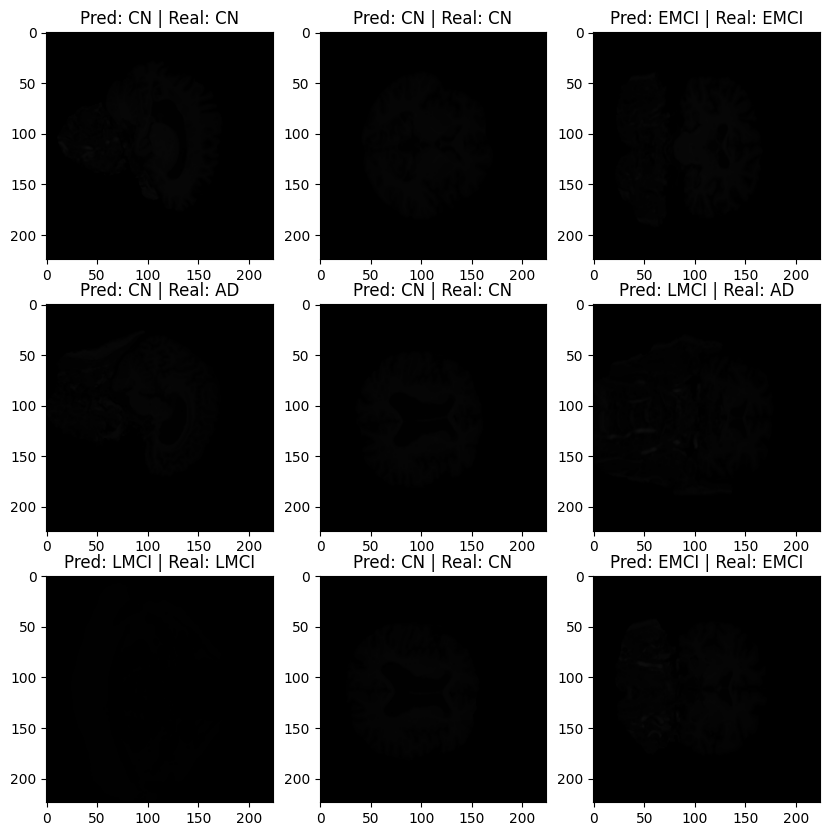

In [12]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

plt.figure(figsize=(10, 10))
for i in range(min(9, len(X_test))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].astype("uint8"))
    
    # Dapatkan label prediksi dan label sebenarnya
    true_label = np.argmax(Y_test[i])
    plt.title("Pred: " + class_names[predicted_labels[i]] + " | Real: " + class_names[true_label])

plt.show()

## 6. Evaluasi

### 6.1 Matriks specificity dan sensitivity

In [15]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

Evaluasi model pada data train

In [16]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_train, Y_train)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

180/180 [==============================] - 231s 1s/step - loss: 0.1075 - accuracy: 0.9644 - specificity: 0.9896 - sensitivity: 0.9582
Loss train set:  0.11130322515964508
Akurasi train set:  0.9616319537162781
Specificity train set:  0.989467442035675
Sensitivity train set:  0.9541666507720947


Evaluasi model pada data test

In [17]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_test, Y_test)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

45/45 [==============================] - 50s 1s/step - loss: 0.8250 - accuracy: 0.7632 - specificity: 0.9264 - sensitivity: 0.7444
Loss train set:  0.8249891400337219
Akurasi train set:  0.7631944417953491
Specificity train set:  0.9263888001441956
Sensitivity train set:  0.7444444298744202


Visualisasi confusion matrix

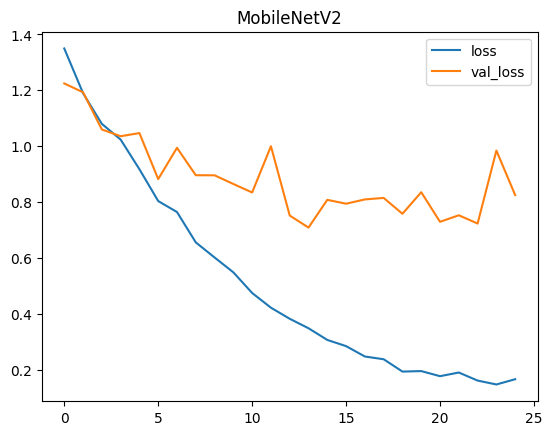

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# loss
fig, ax = plt.subplots()
ax.plot(h_model.history['loss'], label='loss')
ax.plot(h_model.history['val_loss'], label='val_loss')
ax.legend()
plt.title('MobileNetV2')
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\MobileNetV2Loss.png')

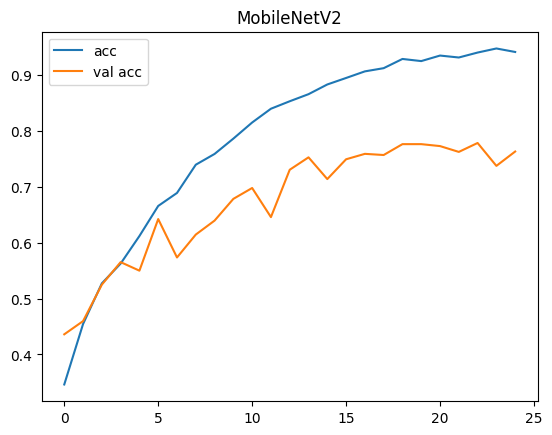

In [19]:
# accuracies
fig, ax = plt.subplots()
ax.plot(h_model.history['accuracy'], label='acc')
ax.plot(h_model.history['val_accuracy'], label='val acc')
ax.legend()
plt.title('MobileNetV2')
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\MobileNetV2Accuracy.png')

In [20]:
# Simpan model
model.save(r"D:\Users\RESA\Coding\Evaluasi\MobileNetV2.h5")

In [21]:
y_preds =  model.predict(X_test)
y_preds

array([[1.45279139e-01, 8.50111246e-01, 4.53190273e-03, 7.77125970e-05],
       [2.06475397e-06, 9.99823034e-01, 1.74020839e-04, 9.75809144e-07],
       [2.11084148e-06, 2.00499140e-04, 9.99796212e-01, 1.17699881e-06],
       ...,
       [2.38258429e-02, 3.00316652e-03, 2.01671313e-07, 9.73170817e-01],
       [7.69006733e-12, 9.99993920e-01, 1.74018109e-11, 6.06375079e-06],
       [1.44523783e-05, 9.98922765e-01, 1.05040264e-03, 1.24261915e-05]],
      dtype=float32)

In [22]:
y_preds_ind = np.argmax(y_preds,axis=1)
y_preds_ind

array([1, 1, 2, ..., 3, 1, 1], dtype=int64)

In [23]:
qwe=np.argmax(Y_test, axis=1)

In [24]:
confusion_matrix(qwe,y_preds_ind)

array([[270,  39,  23,  48],
       [ 14, 271,  18,  35],
       [ 15,  32, 259,  57],
       [ 16,  27,  17, 299]], dtype=int64)

In [25]:
print(classification_report(qwe,y_preds_ind))

              precision    recall  f1-score   support

           0       0.86      0.71      0.78       380
           1       0.73      0.80      0.77       338
           2       0.82      0.71      0.76       363
           3       0.68      0.83      0.75       359

    accuracy                           0.76      1440
   macro avg       0.77      0.76      0.76      1440
weighted avg       0.77      0.76      0.76      1440



In [26]:
model.evaluate(X_test, Y_test)

45/45 [==============================] - 52s 1s/step - loss: 0.8250 - accuracy: 0.7632 - specificity: 0.9264 - sensitivity: 0.7444


[0.8249891400337219,
 0.7631944417953491,
 0.9263888001441956,
 0.7444444298744202]

### 6.3 ROC AUC Curve

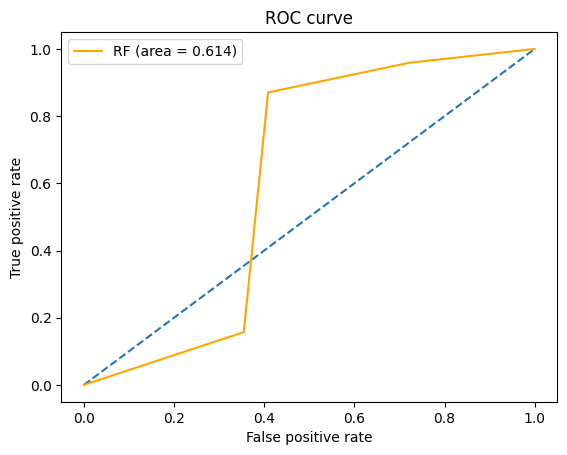

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(qwe, y_preds_ind, pos_label=2)

auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc), color='orange')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Visualization

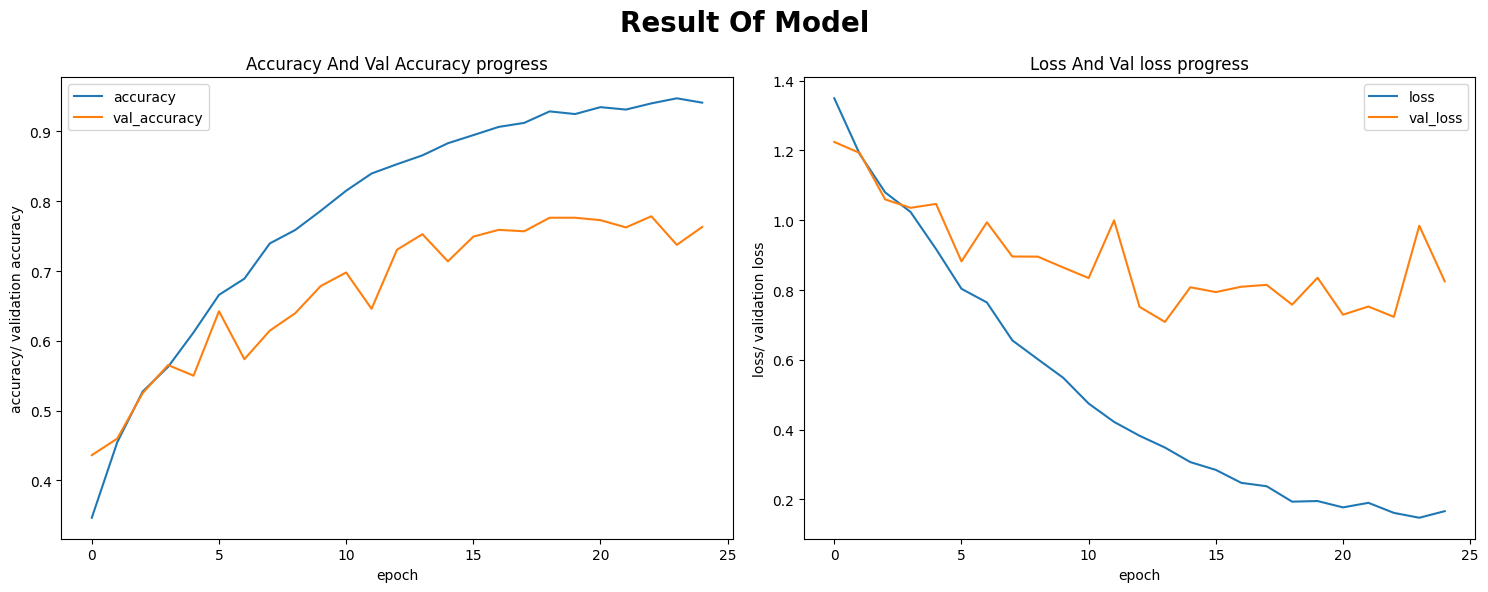

In [28]:
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6))

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_Loss_figure_ResNet50.png')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(h_model.history['accuracy'],h_model.history['val_accuracy'], h_model.history['loss'], h_model.history['val_loss'])

## 7. Cross Validation

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set early stopping criteria
pat = 5 
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint(r'D:\Users\RESA\Coding\Evaluasi\h_MobileNetV2.h5', verbose=1, save_best_only=True)

# Define a function to fit the model
def fit_and_evaluate(X_train, X_test, Y_train, Y_test, EPOCHS=20, BATCH_SIZE=32, model=model):
    results = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.2)
    print("Val Score: ", model.evaluate(X_test, Y_test))
    return results

### 7.1 Training

In [31]:
n_folds = 5
epochs = 20
batch_size = 32

# Save the model history after fitting so that we can plot later
model_history = []

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                                random_state=np.random.randint(1, 1000, 1)[0])
    model_history.append(fit_and_evaluate(X_train, X_test, Y_train, Y_test, epochs, batch_size))
    print("=======" * 12, end="\n\n\n")

Training on Fold:  1


### 7.2 Evaluasi Cross - Validation

In [ ]:
plt.title('Accuracies vs Epochs')
for i in range(len(model_history)):
  plt.plot(model_history[i].history['accuracy'], label=f"Training Fold {i+1}")

plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_vs_Epoch_MobileNetV2.png')

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\TrainAccuracy_vs_ValAccuracy_MobileNetV2.png')